# raw data processing

Currently using this file to learn how to read and plot the raw output files.

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import math
from celluloid import Camera
from IPython import display

In [2]:
def tail(f, lines=1, _buffer=4098):
    """Tail a file and get X lines from the end"""
    lines_found = []
    block_counter = -1
    while len(lines_found) < lines:
        try:
            f.seek(block_counter * _buffer, os.SEEK_END)
        except IOError:  # either file is too small, or too many lines requested
            f.seek(0)
            lines_found = f.readlines()
            break
        lines_found = f.readlines()
        block_counter -= 1
    return lines_found[-lines:]

def read_bid_func(data, n, max_uncertainty):
    midpoints = [float(n) for n in data[0]]
    if n == 1:
        #bids = [max(500, float(n)) for n in data[1]]
        bids = [float(n) for n in data[1]]
        return {"midpoints": midpoints, "uncertainties": [max_uncertainty], "bids": np.array([bids])}
    else:
        uncertainties = np.array([float(n) for n in data[1]])
        bids = np.array([float(n) for n in data[2]])
        bid_mat = []
        for i in range(0, len(bids), len(midpoints)):
            bid_mat.append(np.array(bids[i:i + len(midpoints)]))
        bid_mat = np.array(bid_mat)
        bid_mat = np.maximum(bid_mat, 500)
        return {"midpoints": midpoints, "uncertainties": uncertainties, "bids": bid_mat}

In [3]:
def get_profits(data, signal_counts):
    n_lines = [2 + (s>1) for s in signal_counts]
    n_tot_lines = sum(n_lines) + 1  # extra line for profits
    profits = [[] for _ in range(len(signal_counts))]
    for line_idx in range(n_tot_lines - 1, len(data), n_tot_lines):
        for i in range(len(profits)):
            profits[i].append(float(data[line_idx][i]))
    return profits

def plot_profits(all_results):
    for player_results in all_results.values():
        plt.plot([result['profit'] for result in player_results])
    plt.ylim([45,50])
    plt.show()

def plot_bids(results, xlim = [0,10000], ylim = [0,10000]):
    for res in results:
        plt.plot(res['midpoints'], res['bids'][0])
    plt.plot(range(10000), [one_signal_nash(s, [500,9500], 1000, 4) for s in range(10000)], color='black')
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.show()

def animate_bid_func(all_results):
    fig = plt.figure()
    #fig.set_size_inches(12,12)
    #fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    camera = Camera(fig)

    x = range(10000)
    y = [one_signal_nash(i, [500,9500], 1000, 4) for i in x]
    colors = ['blue','green','yellow','orange']

    for i in range(len(all_results[0])):
        for bidder_idx in all_results:
            midpoints = all_results[bidder_idx][i]['midpoints']
            bids = all_results[bidder_idx][i]['bids'][0]
            plt.plot(midpoints, bids, color=colors[bidder_idx])
        
        plt.plot(x, y, color='black')
        camera.snap()

    anim = camera.animate()
    plt.close()
    return anim

def animate_bid_func2(all_results):
    fig, ax = plt.subplots()
    #fig.set_size_inches(12,12)
    #fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    lines = [
        ax.plot([], 'blue'),
        ax.plot([], 'green'),
        ax.plot([], 'yellow'),
        ax.plot([], 'orange')
    ]

    x = range(10000)
    y = [one_signal_nash(i, [500,9500], 1000, 4) for i in x]

    ax.plot(x,y,color='black')
    
    colors = ['blue','green','yellow','orange']

    def animate(i):
        for bidder_idx in all_results:
            midpoints = all_results[bidder_idx][i]['midpoints']
            bids = all_results[bidder_idx][i]['bids'][0]
            lines[i].set_data((midpoints, bids))
        return lines
        
    anim = FuncAnimation(fig, animate, frames=len(all_results[0]), interval = 5)
    plt.show()

    

def one_signal_nash(signal, bounds, max_uncertainty, n_bidders):
    epsilon = max_uncertainty / 2
    if ((bounds[0] - epsilon) <= signal) and (signal <= (bounds[0] + epsilon)):
        return bounds[0] + 1 / (n_bidders + 1) * (signal - bounds[0] + epsilon)
    elif ((bounds[1] - epsilon) <= signal) and (signal <= (bounds[1] + epsilon)):
        return (math.exp(-32 - 2*math.atan(9 - signal/1000) - 
                2*math.atan((-9000 + signal)/1000))*(201392000000000000000 * math.exp(32) + 
                1000000000000000 * math.exp(2 * math.atan(9 - signal/1000)) + 
                3000000000000000 * math.exp(32 + 2 * math.atan(9 - signal/1000)) - 
                89472000000000000 *math.exp(32) * signal + 14237000000000 * math.exp(32) * signal**2 - 
                875000000 *math.exp(32) * signal**3 + 4500 *  math.exp(32) * signal**4 + math.exp(32) * signal**5))/(5 * (-8000 + 
                signal)**2 * (82000000 - 18000 * signal + signal**2))
    else:
        return signal - epsilon + max_uncertainty / (n_bidders + 1) * math.exp(-n_bidders / max_uncertainty * (signal - (bounds[0] + epsilon)))

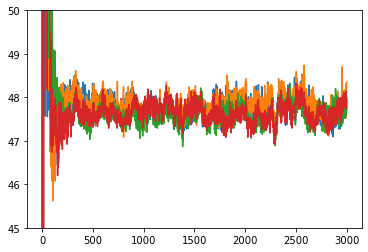

In [4]:
signal_counts = (1,1,1,1)
n_lines = [2 + (s>1) for s in signal_counts]
n_period_means = 199
n_tot_lines = sum(n_lines) + 1  # extra line for profits
signal_str = '_'.join([str(s) for s in signal_counts])
max_uncertainty = 1000

with open(f'F:/Dropbox (Chapman)/Costly Signals/sealed_bid_model/raw_data/common_value_{signal_str}_large.csv', 'r') as csvfile:
    #data = tail(csvfile, n_period_means * n_tot_lines)
    data = csvfile.readlines()
    data = [line.split(',') for line in data]

bid_dict = {i: [] for i in range(len(signal_counts))}
for per_idx in range(0, len(data), n_tot_lines):
    cur_idx = per_idx
    for i in range(len(signal_counts)):
        next_idx = cur_idx + n_lines[i]
        bid_dict[i].append(read_bid_func(data[cur_idx:next_idx], signal_counts[i], max_uncertainty))
        cur_idx = next_idx
    
    for i in range(len(signal_counts)):
        bid_dict[i][-1]["profit"] = float(data[cur_idx][i])


plot_profits(bid_dict)
#plot_bids(bid_dict[3][70:], [0,2000], [0, 2000])
#animate_bid_func2(bid_dict)
# plt.rcParams['animation.ffmpeg_path'] = "C:/Users/rfrench/Downloads/ffmpeg-snapshot.tar/ffmpeg"


# video = animation.to_html5_video()
# html = display.HTML(video)
# display.display(html)
# plt.close()

# profits = get_profits(data, signal_counts)

# for profit in profits:
#     plt.plot(profit)
# plt.ylim([45,50])
# plt.show()

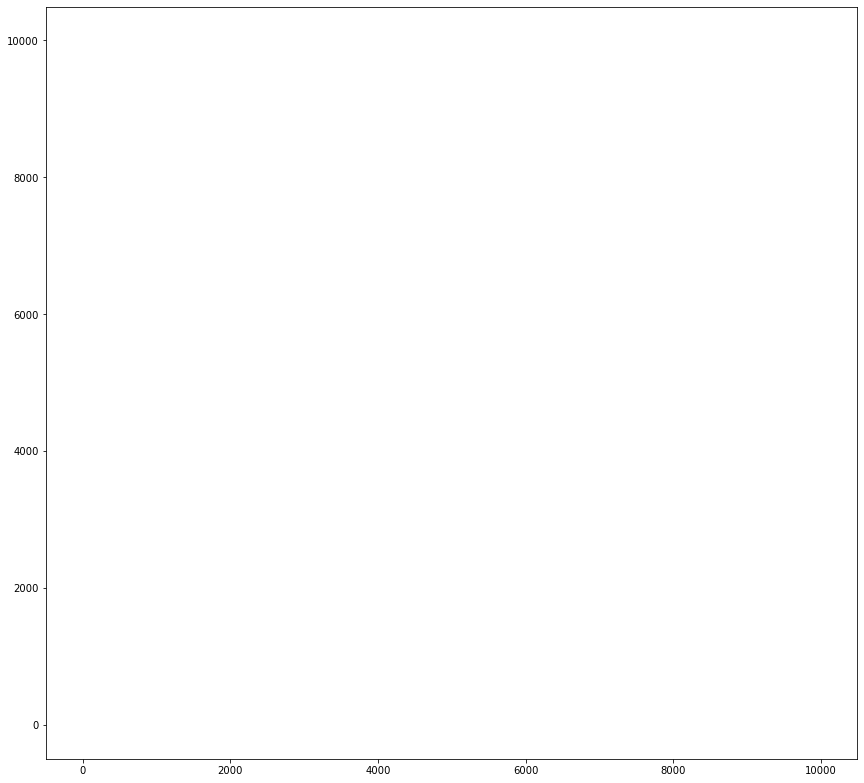

In [27]:

fig, ax = plt.subplots()
fig.set_size_inches(12,12)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
camera = Camera(fig)

x = range(10000)
y = [one_signal_nash(i, [500,9500], 1000, 4) for i in x]
colors = ['blue','green','yellow','orange']

for i in range(len(bid_dict[0])):
#for i in range(50):
    for bidder_idx in bid_dict:
        midpoints = bid_dict[bidder_idx][i]['midpoints']
        bids = bid_dict[bidder_idx][i]['bids'][0]
        plt.plot(midpoints, bids, color=colors[bidder_idx])
        ax.text(7000, 2000 - bidder_idx * 500, colors[bidder_idx] + ": " + str(bid_dict[bidder_idx][i]['profit']))
    
    plt.plot(x, y, color='black')
    ax.text(0.5, 1.01, str(i), transform=ax.transAxes)
    camera.snap()

anim = camera.animate()
plt.close()

In [28]:
from matplotlib.animation import PillowWriter
anim.save("ga_animation.gif", dpi=300, writer=PillowWriter(fps=30))

# Profit Bounds

From Kagel + Levin 1996

In [24]:
n = 4
e = max_uncertainty / 2
lower = (max_uncertainty / (n + 1) - (4 * e**2 / 9000) * (3 * n + 2)/(n * (n +1) * (n + 2)))
upper = lower + (2 * e**2 / 9000) * (1/(n+2))

(lower / 4, upper / 4)

(46.75925925925926, 49.074074074074076)